# Classification of MNIST binary dataset using MPS encoding

In [1]:
from functions import *
from MPS_functions import *

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from sklearn import svm
import math

np.random.seed(88)

## Import MNIST dataset

In [2]:
with np.load('mnist.npz', allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

# Rescale the images from [0,255] to the [0,1] range.
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


### We filter only two classes for binary classification

We choose two numbers: number_0 and number_1 

In [3]:
number_0 = 3; number_1 = 9 

In [4]:
def filter_01(x, y, number_0, number_1):
    keep = (y == number_0) | (y == number_1)
    x, y = x[keep], y[keep]
    return x,y

In [5]:
x_train, y_train = filter_01(x_train, y_train, number_0, number_1)
x_test, y_test = filter_01(x_test, y_test, number_0, number_1)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12080
Number of filtered test examples: 2019


Labels must be 0's and 1's

In [6]:
y_test = np.where(y_test == number_0, 0, y_test)
y_test = np.where(y_test == number_1, 1, y_test)
y_test = np.array(y_test, requires_grad=False)

y_train = np.where(y_train == number_0, 0, y_train)
y_train = np.where(y_train == number_1, 1, y_train)
y_train = np.array(y_train, requires_grad=False)

Take random training and test subsets

In [7]:
def random_subset(x, y, n):
    indices = np.random.choice(len(x), n, replace=False)
    return x[indices], y[indices]

# Set your desired number of samples
n_train = 1000
n_test = 2000

x_train, y_train = random_subset(x_train, y_train, n_train)
x_test, y_test = random_subset(x_test, y_test, n_test)

print(x_train.shape)
print(x_test.shape)

(1000, 28, 28)
(2000, 28, 28)


## Create the superposition state 

We need $L=\left \lceil{\log_2(28\times 28)}\right \rceil = 10$ qubits for the image loading. We define the 10-qubit quantum state:
$$
\begin{align}
|\psi\rangle=\frac{|z\rangle + |W\rangle}{\sqrt{2}}
\end{align}
$$

Where:\
$\bullet |z\rangle =$ image from left to right and up to down\
$\bullet |W\rangle =$ image from up to down and left to right


In [8]:
# Create unnormalized |z> and |W>
def encode_mnist_states(images, reading_order="left_to_right_up_to_down"):
    n_samples, n_rows, n_cols = images.shape

    encoding_qubits=math.ceil(math.log2(n_rows*n_cols))
    state_dim = 2 ** encoding_qubits  

    encoded_states = np.zeros((n_samples, state_dim))

    for i, image in enumerate(images):
        state = np.zeros(state_dim)
        index = 0

        if reading_order == "left_to_right_up_to_down":
            for row in range(n_rows):
                for col in range(n_cols):
                    state[index] = image[row, col]
                    index += 1
        elif reading_order == "up_to_down_left_to_right":
            for col in range(n_cols):
                for row in range(n_rows):
                    state[index] = image[row, col]
                    index += 1
        else:
            raise ValueError("Invalid reading_order. Choose 'left_to_right_up_to_down' or 'up_to_down_left_to_right'.")

        encoded_states[i, :] = state

    return encoded_states

train_left_right = encode_mnist_states(x_train, reading_order="left_to_right_up_to_down")
train_up_down = encode_mnist_states(x_train, reading_order="up_to_down_left_to_right")

test_left_right = encode_mnist_states(x_test, reading_order="left_to_right_up_to_down")
test_up_down = encode_mnist_states(x_test, reading_order="up_to_down_left_to_right")


# Create the superposition quantum state
def create_normalized_vectors(encoded_states_left_right, encoded_states_up_down):
    normalized_vectors = []
    for i in range(len(encoded_states_left_right)):
        left_right = encoded_states_left_right[i]
        up_down = encoded_states_up_down[i]
        
        # Sum the corresponding elements from both arrays
        combined = np.add(left_right, up_down)
        
        # Normalization
        l2_norm = np.linalg.norm(combined, ord=2)
        normalized_vector = combined / l2_norm
        
        normalized_vectors.append(normalized_vector)
    
    return np.array(normalized_vectors, requires_grad = False)

The training and test sets containing the superposition quantum states $|\psi\rangle$ of the images:

In [9]:
training_states = create_normalized_vectors(train_left_right, train_up_down)
test_states = create_normalized_vectors(test_left_right, test_up_down)

## Clasical benchmark using these arrays to perform classification

We are using state $|\psi\rangle$ as input for the clasical model

This linear model uses a numper of parameters p=n_features+1\
In our case this is 1024+1=1025 trainable parameters

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Replace with your data loading code
X_train = training_states
X_test = test_states

# Create a LogisticRegression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9665


## Using the MPS approximation of the image states

We will use the approximated states

$$
\begin{align}
|\tilde{\psi}\rangle=\text{MPS}_\chi (|\psi\rangle)
\end{align}
$$

where $\chi$ is the bond dimension which controls the degree of compression of the image.

Take an example

In [11]:
def norm_2(exact,approximate):
    length = len(exact)
    sum = 0
    for i in range(length):
        sum = sum + (exact[i]-approximate[i])**2
    return np.sqrt(sum/length)[0]

def fidelity(exact,approximate):
    return np.abs(exact @ approximate)**2

In [12]:
L = 10; d = 2; chis = [1,2,4,8,16,32]

# We take an element of the training set as an example
state = training_states[0]

for chi in chis:
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fid = fidelity(state,approx_state)
    L2_norm = norm_2(state,approx_state)
    print('Chi ='+ str(chi))
    print('Fidelity: ', fid[0])
    print('L2 norm: ', L2_norm)
    print('')

Chi =1
Fidelity:  0.26938966383054375
L2 norm:  0.03064961976767334

Chi =2
Fidelity:  0.4329252552066784
L2 norm:  0.0258462038583748

Chi =4
Fidelity:  0.7252576143587157
L2 norm:  0.017023617485813113

Chi =8
Fidelity:  0.9144238715711407
L2 norm:  0.009243332804952143

Chi =16
Fidelity:  0.9975186082969193
L2 norm:  0.0015571574105562739

Chi =32
Fidelity:  1.0000000000000027
L2 norm:  1.0175162965938628e-16



Now we choose a $\chi$ and we obtain the correspondent approximated training and test sets

In [13]:
chi = 1

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

Clasical benchmark with the approximation state $|\tilde{\psi}\rangle$

In [14]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.796


In [15]:
save_1 = training_approx_states[0]

To ensure that Pennylane does not try to compute the grad:

In [16]:
x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

# Variational model 

In [17]:
# Number of layes of the model
# The number of trainabla parameters will be 3*layers*loading_qubits
layers = 1

Here we present the variational quantum circuit which will be used as QNN\
We assume it is initialized with $|\tilde{\psi}\rangle$ loaded in the amplitudes

In [18]:
# We need L = 10 qubits to encode the image using MPS and one extra qubit to perform classification

loading_qubits = int(np.log2(len(training_states[0])))
qubits = int(loading_qubits+1) 

dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev, interface="autograd")
def QNN(params, x, y):
    """
    Args:
        params: array of parameters
        x: single input vector
        y: single output state density matrix corresponding to each label

    Returns: fidelity between output state and input
    """
    loading_qubits = int(np.log2(len(x)))
    qml.AmplitudeEmbedding(x, wires=list(range(loading_qubits)))

    for p in range(len(params)):
        qml.CRot(params[p][0],params[p][1],params[p][2], wires=[p,loading_qubits])

    return qml.expval(qml.Hermitian(y, wires=[loading_qubits]))

In [19]:
# We need L = 10 qubits to encode the image using MPS and one extra qubit to perform classification

loading_qubits = int(np.log2(len(training_states[0])))
qubits = int(loading_qubits+1) 

dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev, interface="autograd")
def QNN(params, x, y):
    """
    Args:
        params: array of parameters
        x: single input vector
        y: single output state density matrix corresponding to each label

    Returns: fidelity between output state and input
    """
    loading_qubits = int(np.log2(len(x)))
    layers = np.shape(params)[0]//loading_qubits

    qml.AmplitudeEmbedding(x, wires=list(range(loading_qubits)))

    for j in range(layers):
        for p in range(loading_qubits):
            qml.CRot(params[j*loading_qubits+p][0],params[j*loading_qubits+p][1],params[j*loading_qubits+p][2], wires=[p,loading_qubits])

    return qml.expval(qml.Hermitian(y, wires=[loading_qubits]))

The classification qubits assigns labels according to the fidelity with respect to the label states $|0\rangle$ and $|1\rangle$

In [20]:
label_0 = [[1,0],[0,0]]
label_1 = [[0,0],[0,1]]
dm_labels = [label_0, label_1]
dm_labels = np.array(dm_labels, requires_grad=False)

(<Figure size 1400x1200 with 1 Axes>, <Axes: >)


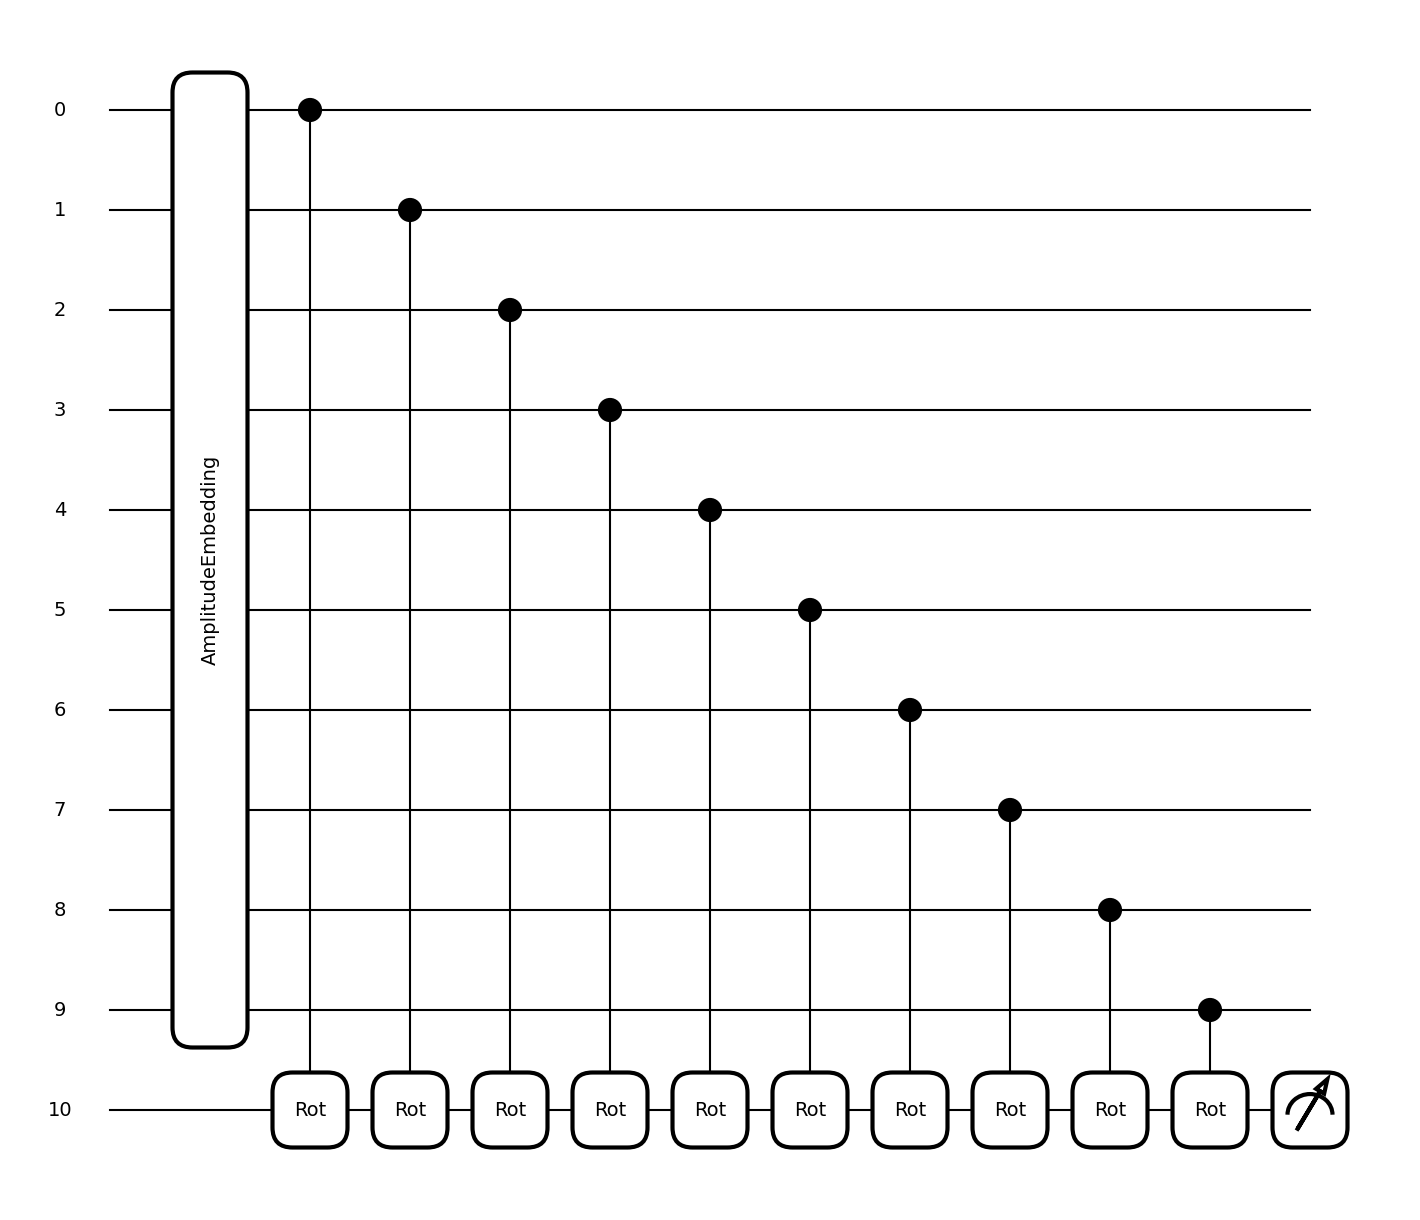

In [21]:
# Initialize QNN with random weights
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) #The number of parameters is 3*number of layers
print(qml.draw_mpl(QNN, show_all_wires=True)(params,training_states[0],dm_labels[0]))

In [22]:
def cost(params, x, y, dm_labels):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    
    for i in range(len(x)):
        f = QNN(params, x[i], dm_labels[int(y[i])])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

def test(params, x, y, dm_labels):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: QNN(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels] 
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

Training:

In [23]:
#Train using Adam optimizer and evaluate the classifier
learning_rate = 0.05
epochs = 20
batch_size = 8
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

#These are the predictions with random weights
print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

# Now results with optimization
for it in range(epochs): #In each epoch I go through all the training data which is splitted in batches
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size): #AFTER INTRODUCING A BATCH, PARAMETERS ARE UPDATED
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.217134 | Train accuracy: 0.717000 | Test accuracy: 0.694500
Epoch:  2 | Loss: 0.212261 | Train accuracy: 0.734000 | Test accuracy: 0.695500
Epoch:  3 | Loss: 0.211097 | Train accuracy: 0.731000 | Test accuracy: 0.702000
Epoch:  4 | Loss: 0.210846 | Train accuracy: 0.739000 | Test accuracy: 0.710500
Epoch:  5 | Loss: 0.211266 | Train accuracy: 0.747000 | Test accuracy: 0.715500
Epoch:  6 | Loss: 0.211613 | Train accuracy: 0.747000 | Test accuracy: 0.715500
Epoch:  7 | Loss: 0.211821 | Train accuracy: 0.747000 | Test accuracy: 0.718500
Epoch:  8 | Loss: 0.211705 | Train accuracy: 0.744000 | Test accuracy: 0.715500
Epoch:  9 | Loss: 0.212024 | Train accuracy: 0.749000 | Test accuracy: 0.717500
Epoch: 10 | Loss: 0.211737 | Train accuracy: 0.742000 | Test accuracy: 0.719500
Epoch: 11 | Loss: 0.211246 | Train accuracy: 0.733000 | Test accuracy: 0.705500
Epoch: 12 | Loss: 0.211499 | Train accur

In [24]:
print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch: 20 | Loss: 0.211988 | Train accuracy: 0.737000 | Test accuracy: 0.710500


## $\chi=2$

In [25]:
chi = 2

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

Classical benchmark:

In [26]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9375


In [27]:
save_2 = training_approx_states[0]

In [28]:
#Train using Adam optimizer and evaluate the classifier
learning_rate = 0.05
epochs = 20
batch_size = 8
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

#These are the predictions with random weights
print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

# Now results with optimization
for it in range(epochs): #In each epoch I go through all the training data which is splitted in batches
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size): #AFTER INTRODUCING A BATCH, PARAMETERS ARE UPDATED
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.192891 | Train accuracy: 0.844000 | Test accuracy: 0.869000
Epoch:  2 | Loss: 0.190542 | Train accuracy: 0.838000 | Test accuracy: 0.858500
Epoch:  3 | Loss: 0.189786 | Train accuracy: 0.842000 | Test accuracy: 0.862500
Epoch:  4 | Loss: 0.189153 | Train accuracy: 0.846000 | Test accuracy: 0.860000
Epoch:  5 | Loss: 0.188780 | Train accuracy: 0.851000 | Test accuracy: 0.865000
Epoch:  6 | Loss: 0.187786 | Train accuracy: 0.847000 | Test accuracy: 0.865000
Epoch:  7 | Loss: 0.185721 | Train accuracy: 0.850000 | Test accuracy: 0.869500
Epoch:  8 | Loss: 0.186039 | Train accuracy: 0.854000 | Test accuracy: 0.876500
Epoch:  9 | Loss: 0.184689 | Train accuracy: 0.859000 | Test accuracy: 0.875000
Epoch: 10 | Loss: 0.183792 | Train accuracy: 0.863000 | Test accuracy: 0.881000
Epoch: 11 | Loss: 0.183447 | Train accuracy: 0.856000 | Test accuracy: 0.876500
Epoch: 12 | Loss: 0.183412 | Train accur

In [29]:
print(fidelity(training_states[0],save_1))
print(fidelity(training_states[0],save_2))
print(fidelity(save_2,save_1))

0.26938966383054375
0.4329252552066784
0.6028065859076303


## $\chi=4$

In [30]:
chi = 4

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

In [31]:
#Train using Adam optimizer and evaluate the classifier
learning_rate = 0.05
epochs = 20
batch_size = 8
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

#These are the predictions with random weights
print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

# Now results with optimization
for it in range(epochs): #In each epoch I go through all the training data which is splitted in batches
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size): #AFTER INTRODUCING A BATCH, PARAMETERS ARE UPDATED
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.193354 | Train accuracy: 0.834000 | Test accuracy: 0.854500
Epoch:  2 | Loss: 0.192115 | Train accuracy: 0.822000 | Test accuracy: 0.845000
Epoch:  3 | Loss: 0.188651 | Train accuracy: 0.853000 | Test accuracy: 0.874000
Epoch:  4 | Loss: 0.181733 | Train accuracy: 0.870000 | Test accuracy: 0.882500
Epoch:  5 | Loss: 0.180990 | Train accuracy: 0.875000 | Test accuracy: 0.893000
Epoch:  6 | Loss: 0.179863 | Train accuracy: 0.871000 | Test accuracy: 0.881500
Epoch:  7 | Loss: 0.179330 | Train accuracy: 0.871000 | Test accuracy: 0.877500
Epoch:  8 | Loss: 0.179278 | Train accuracy: 0.870000 | Test accuracy: 0.878500
Epoch:  9 | Loss: 0.179285 | Train accuracy: 0.876000 | Test accuracy: 0.887000
Epoch: 10 | Loss: 0.179328 | Train accuracy: 0.883000 | Test accuracy: 0.896000
Epoch: 11 | Loss: 0.179226 | Train accuracy: 0.889000 | Test accuracy: 0.900500
Epoch: 12 | Loss: 0.179077 | Train accur

In [32]:
model = LogisticRegression()
model.fit(training_approx_states, y_train)
y_pred = model.predict(test_approx_states)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.958


## $\chi=32$

In [33]:
chi = 32

training_approx_states = []
test_approx_states = []

for element in training_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    training_approx_states.append(approximation[0])

for element in test_states:
    mps = MPS(element, L, d, chi)
    approximation = MPS_contraction(mps, L, d)
    approximation = np.reshape(approximation, (1, -1))
    test_approx_states.append(approximation[0])

x_train = np.array(training_approx_states, requires_grad=False)
x_test = np.array(test_approx_states, requires_grad=False)

In [34]:
#Train using Adam optimizer and evaluate the classifier
learning_rate = 0.05
epochs = 20
batch_size = 8
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

np.random.seed(88)
params = np.random.uniform(size=(layers*loading_qubits, 3), requires_grad=True) 

predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, test_states, y_test, dm_labels)

#These are the predictions with random weights
print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))

# Now results with optimization
for it in range(epochs): #In each epoch I go through all the training data which is splitted in batches
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size): #AFTER INTRODUCING A BATCH, PARAMETERS ARE UPDATED
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, dm_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, dm_labels)
    accuracy_train = accuracy_score(y_train, predicted_train) 
    loss = cost(params, x_train, y_train, dm_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, dm_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.325183 | Train accuracy: 0.479000 | Test Accuracy: 0.501500
Epoch:  1 | Loss: 0.186045 | Train accuracy: 0.934000 | Test accuracy: 0.938500
Epoch:  2 | Loss: 0.173697 | Train accuracy: 0.933000 | Test accuracy: 0.948500
Epoch:  3 | Loss: 0.167176 | Train accuracy: 0.947000 | Test accuracy: 0.958000
Epoch:  4 | Loss: 0.166484 | Train accuracy: 0.948000 | Test accuracy: 0.957000
Epoch:  5 | Loss: 0.166608 | Train accuracy: 0.946000 | Test accuracy: 0.957500
Epoch:  6 | Loss: 0.166744 | Train accuracy: 0.945000 | Test accuracy: 0.954500
Epoch:  7 | Loss: 0.166837 | Train accuracy: 0.945000 | Test accuracy: 0.954500
Epoch:  8 | Loss: 0.166898 | Train accuracy: 0.946000 | Test accuracy: 0.953500
Epoch:  9 | Loss: 0.166938 | Train accuracy: 0.945000 | Test accuracy: 0.953500
Epoch: 10 | Loss: 0.166966 | Train accuracy: 0.946000 | Test accuracy: 0.953000
Epoch: 11 | Loss: 0.166987 | Train accuracy: 0.946000 | Test accuracy: 0.952500
Epoch: 12 | Loss: 0.167003 | Train accur